In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold

In [78]:
df_data_test = pd.read_csv("BigMart_Dataset_Testset.csv")
df_data_train = pd.read_csv("BigMart_Dataset_Trainset.csv")
df_sample_submission = pd.read_csv("sample_submission.csv")

In [3]:
def categorical_numric(df):
  for i in df:
    if df[i].dtype == 'object':
      df[i] = df[i].astype('category')
      df[i] = df[i].cat.codes
  return df

In [4]:
def categorical_plot(label,y):
  sns.countplot(label, data = y, palette ='plasma')

In [5]:
def denisty_plot(x_label, y):
  sns.set_style('whitegrid')
  plot = sns.kdeplot(np.array(y),x=x_label)
  plot.set(xlabel=x_label)
  plt.show()

In [6]:
def plot(iterations,y,x_lables=None,title=None):
   x = [i for i in range(iterations)]
   plt.figure(figsize =(9, 6))
   for i in range(y.shape[1]):
      plt.plot(x,y[:,i], label = x_lables[i])
   plt.xlabel('Ittertion')
   plt.ylabel("Cost")
   plt.title(title)
   plt.legend()
   plt.show()

با استفاده از categorical_numric مقادیر دسته بندی به عدد تبدیل میشوند.

In [7]:
data_test = categorical_numric(df_data_test)
data_train = categorical_numric(df_data_train)

In [8]:
data_test = data_test.to_numpy()
data_train = data_train.to_numpy()

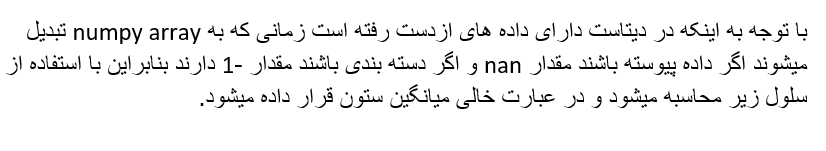

In [90]:
def remove_missing_values(data_train):
  for i in range(data_train.shape[1]):
    tmp = data_train[:,i]
    data_train[:,i] = np.where(np.isnan(tmp), np.nanmean(tmp), tmp)
    data_train[:,i] = np.where(tmp == -1, np.nanmean(tmp), tmp)
  return data_train
data_train = remove_missing_values(data_train)

قسمت ب

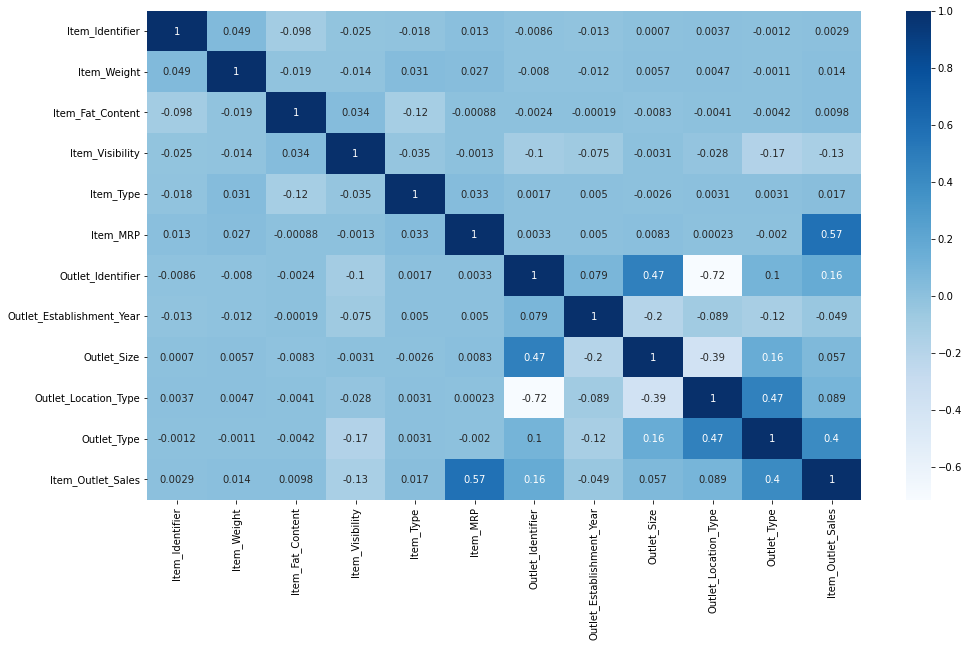

In [10]:
corr_matrix = df_data_train.corr()
plt.figure(figsize =(16, 9))
sns.heatmap(corr_matrix, annot=True,cmap="Blues")
plt.show()

قسمت ج

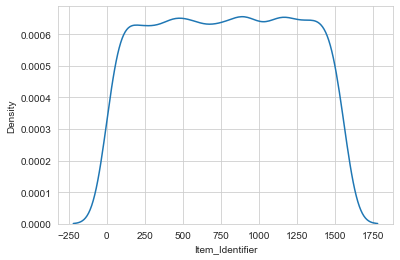

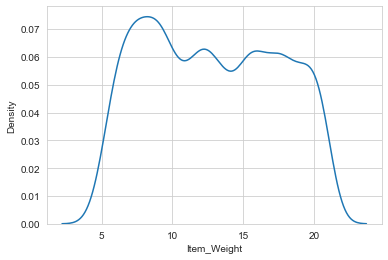

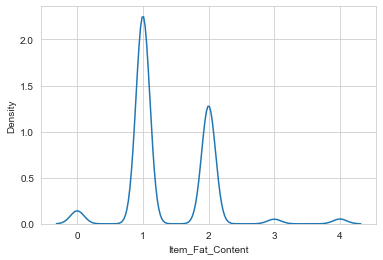

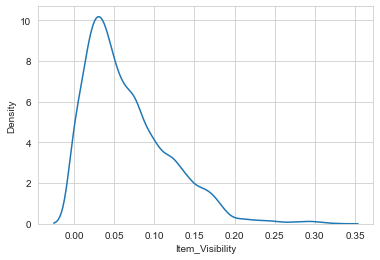

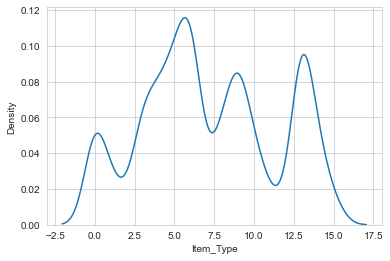

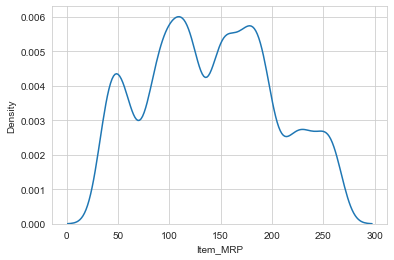

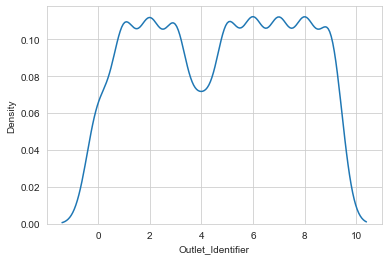

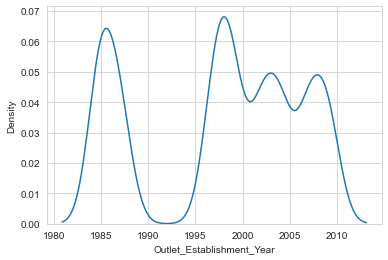

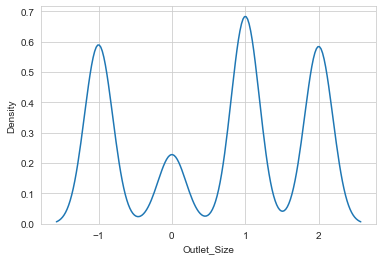

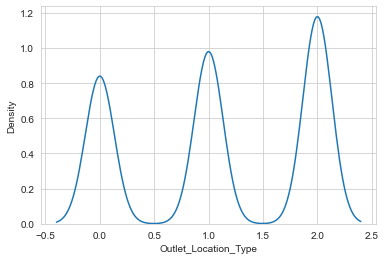

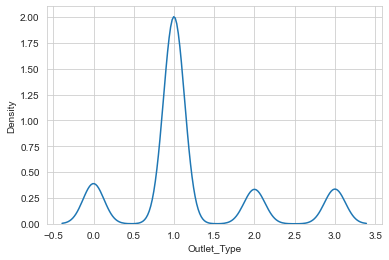

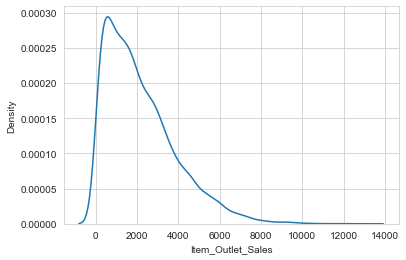

In [11]:
for column in df_data_train.columns:
  denisty_plot(column,df_data_train[column])

In [12]:
def covarience(x):
  cov = np.zeros((x.shape[0],x.shape[0]))
  n = x.shape[1] - 1 
  for i in range(x.shape[0]):
    for j in range(x.shape[0]):
      cov[i,j] = np.dot(x[i] - np.mean(x[i]),x[j].T - np.mean(x[j]))/(n)
  return cov

قسمت د

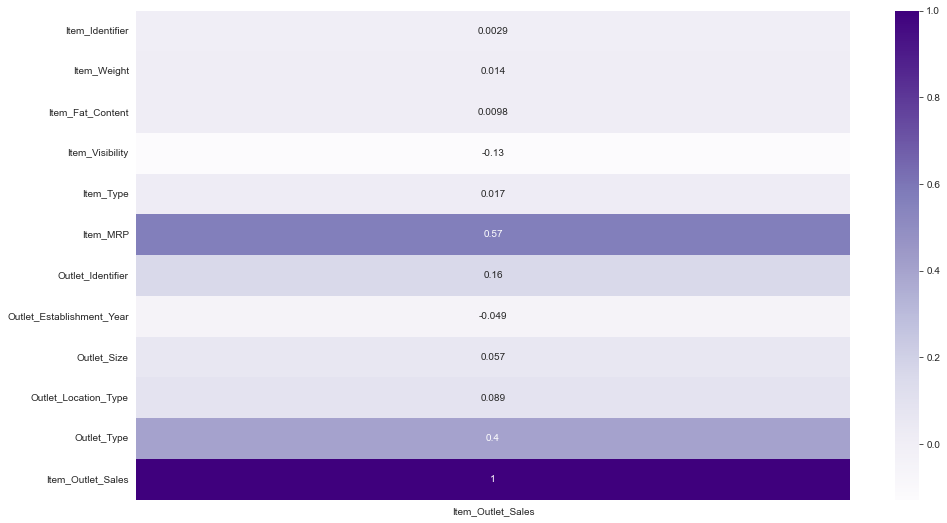

In [13]:
tmp = corr_matrix['Item_Outlet_Sales'].to_frame()
plt.figure(figsize =(16, 9))
sns.heatmap(tmp, annot=True,cmap="Purples")
plt.show()

In [14]:
def normalization(input_data):# توی این قسمت تابعی برای نرمال سازی استفاده شده است که تمامی ویژگی ها را به بازه صفر تا یک میبرد مشابه تابع MinMaxScaler
  result = np.zeros(input_data.shape)
  for i in range(input_data.shape[1]):
    result[:,i] = (input_data[:,i] - input_data[:,i].min()) / (input_data[:,i].max() - input_data[:,i].min())
  return result

In [89]:
def train_test_split(data,ratio=0.8):
  random_list = np.random.permutation(data.shape[0])
  x = data[:,:data.shape[1] - 1]
  y = data[:,data.shape[1] - 1]
  x = x[random_list,:]
  y = y[random_list]
  trainratio = int(x.shape[0]*ratio)

  x_train = x[:trainratio,:] 
  y_train = y[:trainratio]

  x_test = x[trainratio:,:]
  y_test = y[trainratio:]

  return x_train,y_train,x_test,y_test

In [16]:
class linear_regresion:
  def __init__(self,x_train, learning_rate=0.01,iteration=100,batch_size=64,landa=0.01):
      np.random.seed(1)
      self.number_of_features = x_train.shape[1]
      self.number_of_training_examples = x_train.shape[0]
      self.learning_rate = learning_rate
      self.iteration = iteration
      self.batch_size = batch_size
      self.theta = np.random.rand(self.number_of_features + 1)
      self.cost = np.zeros((iteration,1))
      self.landa = landa

  def reset_parameters(self,learning_rate=0.01, iteration=100, batch_size=64,landa=0.01):
      np.random.seed(1)
      self.learning_rate = learning_rate
      self.iteration = iteration
      self.batch_size = batch_size
      self.theta = np.random.rand(self.number_of_features + 1)
      self.cost = np.zeros((iteration,1))
      self.landa = landa

In [17]:
def hypothesis(theta,x_train):
  h_theta = np.zeros((x_train.shape[0]))
  for i in range(x_train.shape[0]):
    h_theta[i] = np.matmul(x_train[i],theta[1:]) + theta[0]
  return h_theta

In [18]:
def MSE_function(h,y,m,landa=None):
  return (1 / (2 * m) ) * sum(np.square(h - y))

In [19]:
def MAE_function(h,y,m,landa=None):
  return (1 / m) * sum(np.absolute(h - y))

In [20]:
def Ridge_function(h, y, m, theta, landa):
  return MSE_function(h, y, m) + ((landa / (2 * m)) * np.sum(theta**2))

In [21]:
def Lasso_function(h, y, m, theta, landa):
  return MSE_function(h, y, m) + ((landa / (2 * m)) * np.sum(np.abs(theta)))

In [22]:
def evaluate(theta, x_data, y_data ,cost_function,landa=None):
    h = hypothesis(theta, x_data)
    return cost_function(h, y_data, x_data.shape[0], landa)

In [23]:
def BGD_Mse(Regression,x_train,y_train):
  for iter in range(Regression.iteration):
    h = hypothesis(Regression.theta,x_train)
    Regression.theta[0] = Regression.theta[0] - (Regression.learning_rate/x_train.shape[0]) * sum(h - y_train)
    for j in range(1,Regression.number_of_features + 1):
      Regression.theta[j] = Regression.theta[j] - (Regression.learning_rate/x_train.shape[0]) * np.sum((h-y_train) * x_train.transpose()[j-1])
    h = hypothesis(Regression.theta, x_train)
    Regression.cost[iter] = MSE_function(h,y_train,x_train.shape[0])
  return Regression.cost, Regression.theta

In [24]:
def BGD_Ridge(Regression,x_train,y_train):
  for iter in range(Regression.iteration):
    h = hypothesis(Regression.theta,x_train)
    Regression.theta[0] = Regression.theta[0] - (Regression.learning_rate/x_train.shape[0]) * ( sum(h - y_train) +  Regression.landa * 2 * Regression.theta[0])
    for j in range(1,Regression.number_of_features + 1):
      l2 = 2 * Regression.landa * Regression.theta[j]
      Regression.theta[j] = Regression.theta[j] - (Regression.learning_rate/x_train.shape[0]) * (np.sum((h-y_train) * x_train.transpose()[j-1]) + l2)
    h = hypothesis(Regression.theta, x_train)
    Regression.cost[iter] = Ridge_function(h,y_train,x_train.shape[0],Regression.theta,Regression.landa)
  return Regression.cost, Regression.theta  

In [25]:
def BGD_Lasso(Regression,x_train,y_train):
  for iter in range(Regression.iteration):
    h = hypothesis(Regression.theta,x_train)
    Regression.theta[0] = Regression.theta[0] - (Regression.learning_rate/x_train.shape[0]) * ( sum(h - y_train) +  Regression.landa * np.sign(Regression.theta[0]))
    for j in range(1,Regression.number_of_features + 1):
      l1 = Regression.landa * np.sign(Regression.theta[j])
      Regression.theta[j] = Regression.theta[j] - (Regression.learning_rate/x_train.shape[0]) * (np.sum((h-y_train) * x_train.transpose()[j-1]) + l1)
    h = hypothesis(Regression.theta, x_train)
    Regression.cost[iter] = Lasso_function(h,y_train,x_train.shape[0],Regression.theta,Regression.landa)
  return Regression.cost, Regression.theta  

In [26]:
def Kfold(Regression, number_kfold, x_train, y_train, Regression_method):
    kf = KFold(n_splits=number_kfold)
    train_cost = np.zeros((Regression.iteration,number_kfold))
    dev_cost = np.zeros((Regression.iteration,number_kfold))
    x_lables = [0] * Regression.iteration
    i = 0 

    for train_index, val_index in kf.split(x_train):
        x_training_data = x_train[train_index,:]
        x_validation_data = x_train[val_index,:]
        
        y_training_data = y_train[train_index]
        y_validation_data = y_train[val_index]
        
        Regression.reset_parameters()
        BGD_cost, BGD_theta = Regression_method(Regression,x_training_data,y_training_data)
        
        train_cost[:,i] = BGD_cost[:,0]
        dev_cost[:,i] = evaluate(BGD_theta, x_validation_data, y_validation_data, MSE_function)
        x_lables[i] = f'Cost in {i+1}th Fold'
        i = i + 1

    return train_cost, dev_cost, x_lables



In [27]:
data_train = normalization(data_train)

قسمت ه 

In [28]:
x_train,y_train,x_test,y_test = train_test_split(data_train,0.8)
Regression = linear_regresion(x_train)


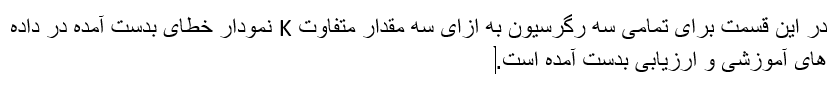

BGD_Mse

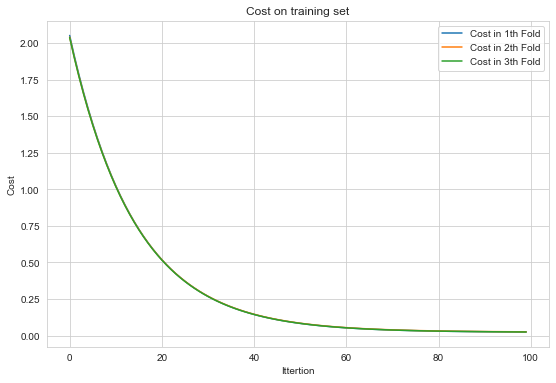

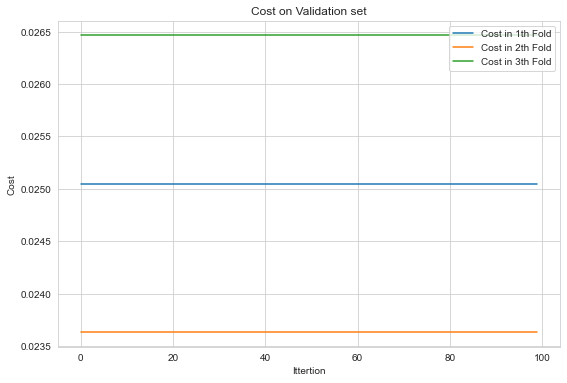

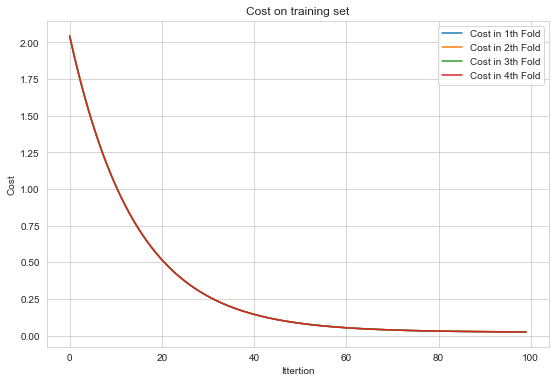

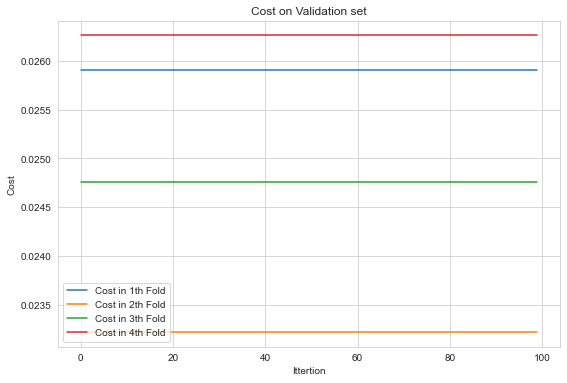

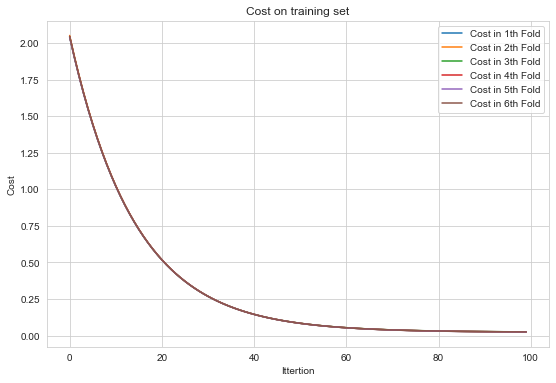

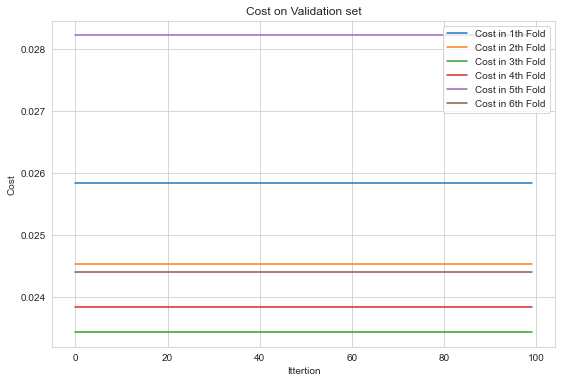

In [29]:
number_kfold = [3,4,6]
x_train,y_train,x_test,y_test = train_test_split(data_train,0.8)
for i in number_kfold:
  train_cost, dev_cost ,x_lables = Kfold(Regression, i, x_train,y_train, BGD_Mse)
  plot(Regression.iteration, train_cost, x_lables,title = "Cost on training set")
  plot(Regression.iteration, dev_cost, x_lables,title = "Cost on Validation set")

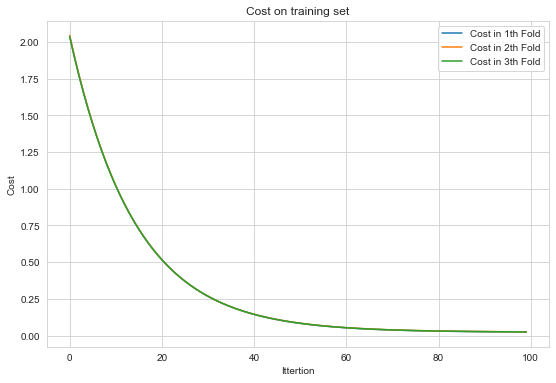

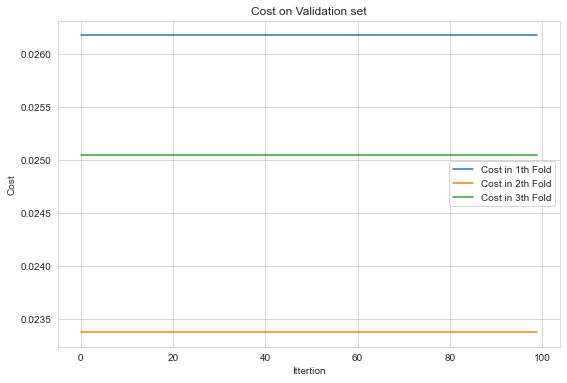

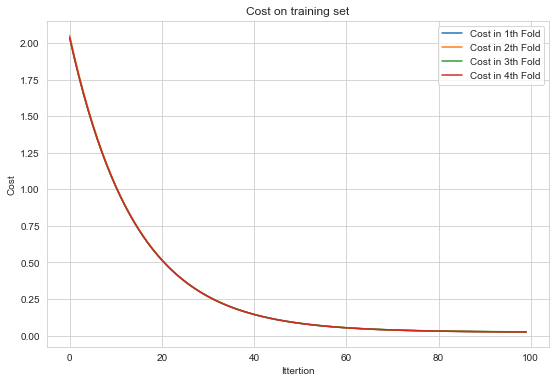

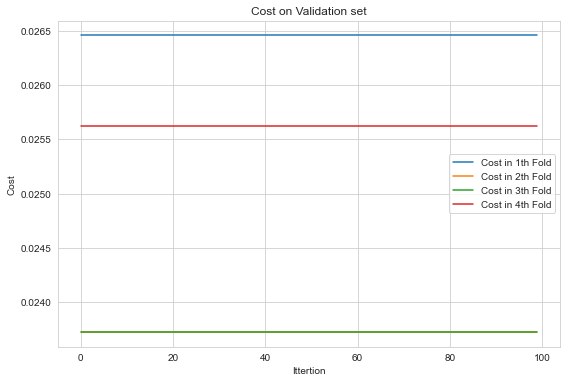

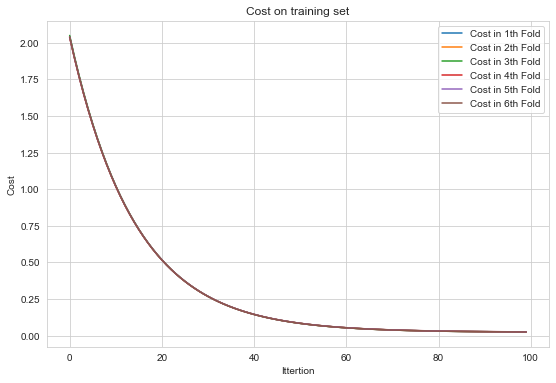

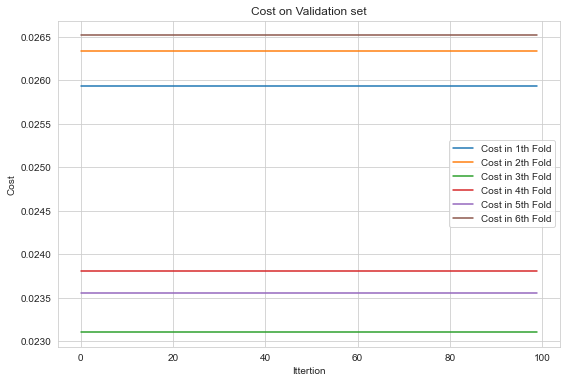

In [30]:
number_kfold = [3,4,6]
x_train,y_train,x_test,y_test = train_test_split(data_train,0.6)
Regression = linear_regresion(x_train)
for i in number_kfold:
  train_cost, dev_cost ,x_lables = Kfold(Regression, i, x_train,y_train, BGD_Mse)
  plot(Regression.iteration, train_cost, x_lables,title = "Cost on training set")
  plot(Regression.iteration, dev_cost, x_lables,title = "Cost on Validation set")



BGD_Ridge

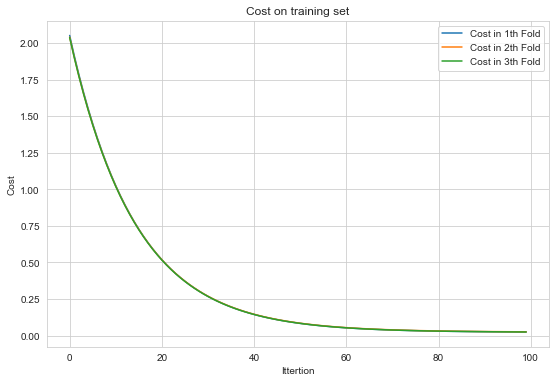

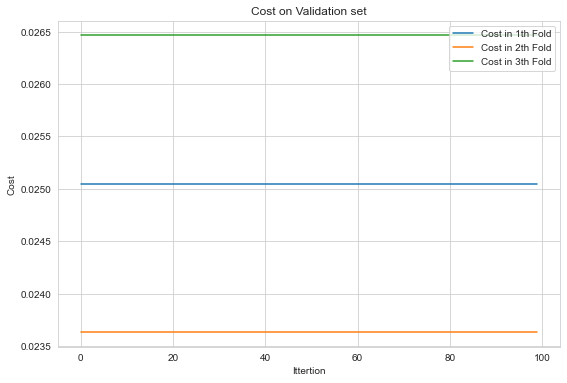

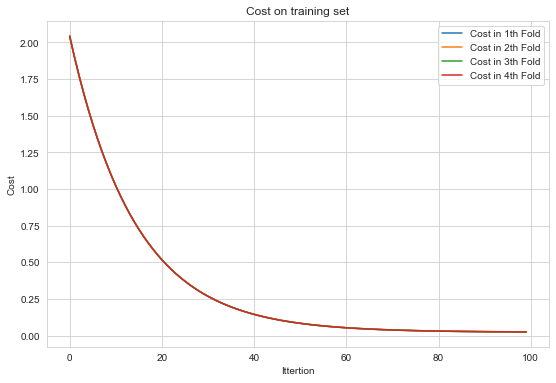

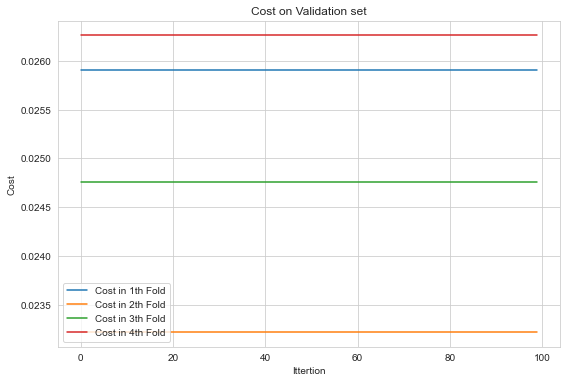

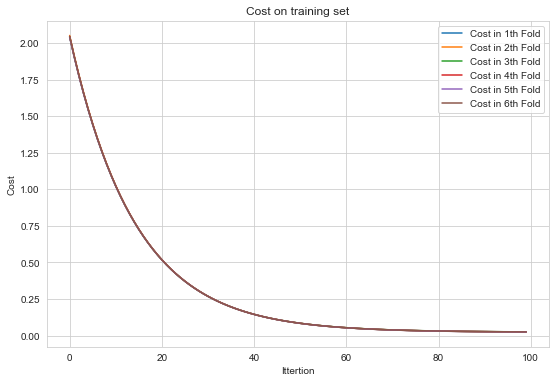

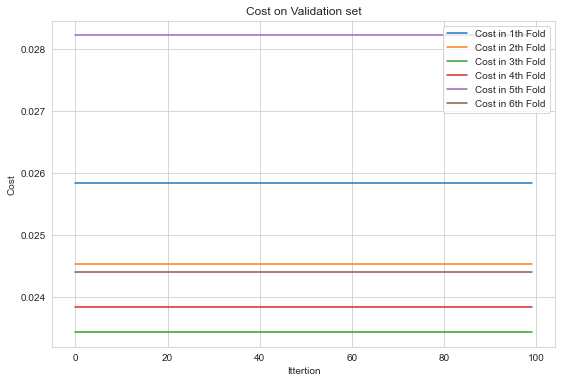

In [31]:
number_kfold = [3,4,6]
x_train,y_train,x_test,y_test = train_test_split(data_train,0.8)
Regression = linear_regresion(x_train)
for i in number_kfold:
  train_cost, dev_cost ,x_lables = Kfold(Regression, i, x_train,y_train, BGD_Ridge)
  plot(Regression.iteration, train_cost, x_lables,title = "Cost on training set")
  plot(Regression.iteration, dev_cost, x_lables,title = "Cost on Validation set")


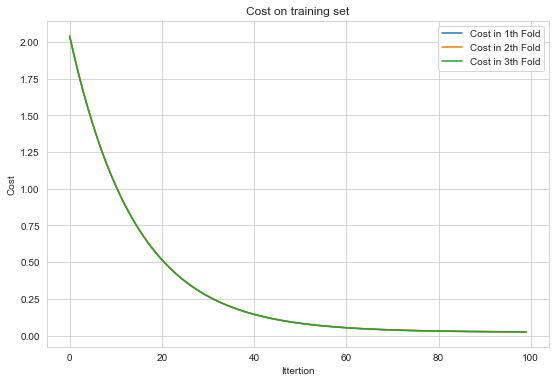

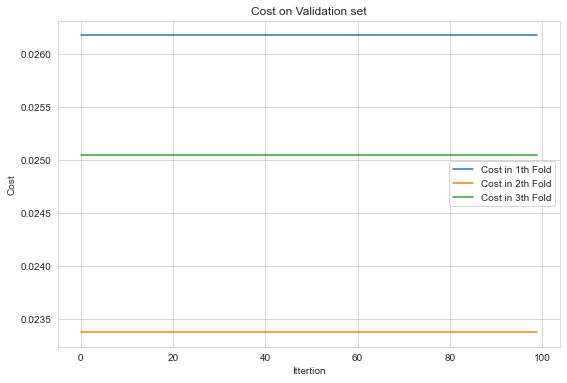

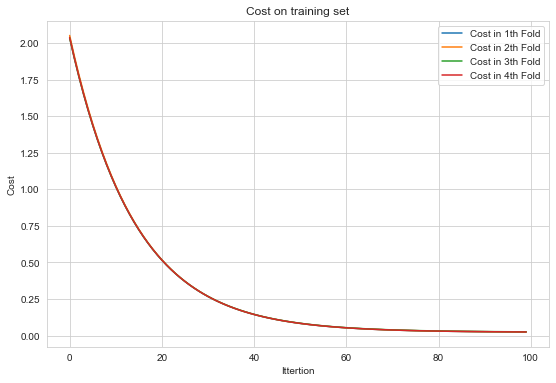

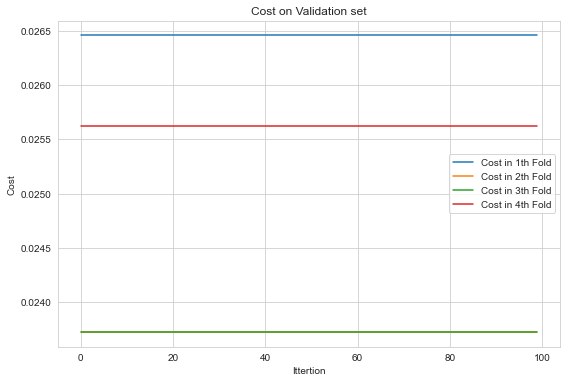

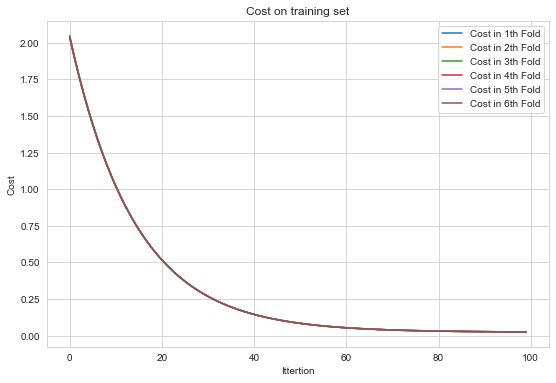

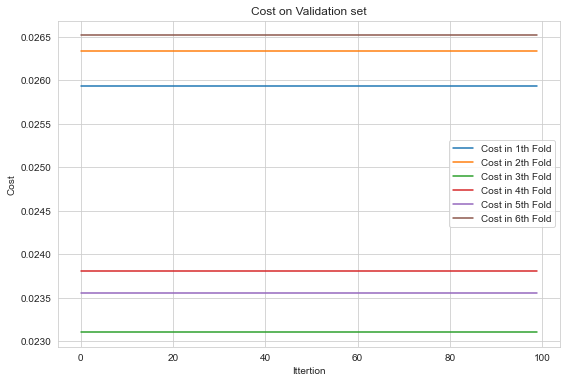

In [32]:
number_kfold = [3,4,6]
x_train,y_train,x_test,y_test = train_test_split(data_train,0.6)
Regression = linear_regresion(x_train)
for i in number_kfold:
  train_cost, dev_cost ,x_lables = Kfold(Regression, i, x_train,y_train, BGD_Ridge)
  plot(Regression.iteration, train_cost, x_lables,title = "Cost on training set")
  plot(Regression.iteration, dev_cost, x_lables,title = "Cost on Validation set")


BGD_Lasso قسمت ک

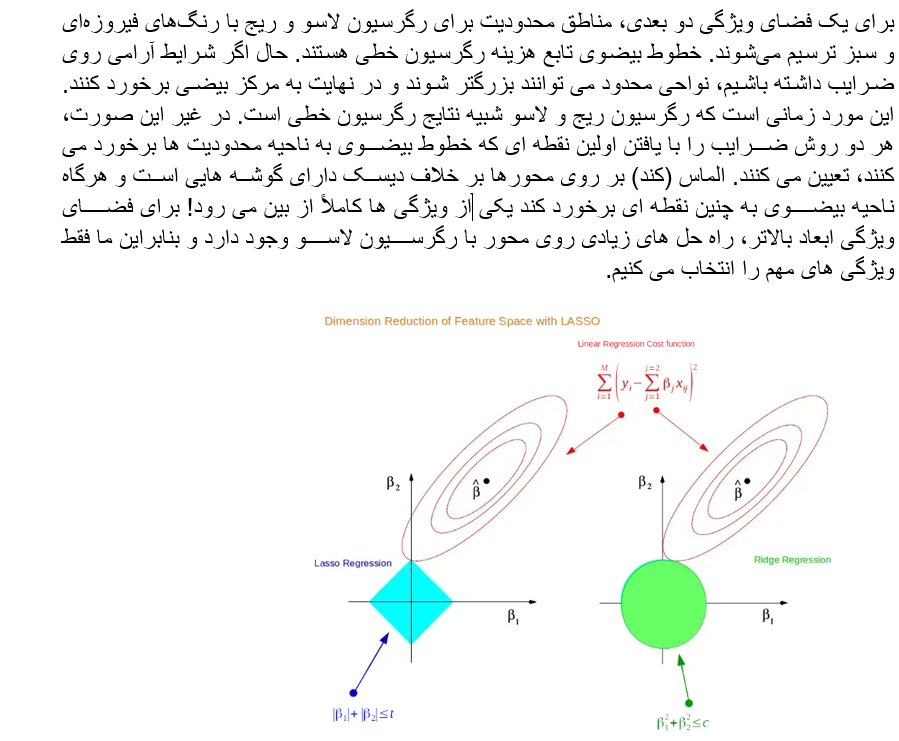

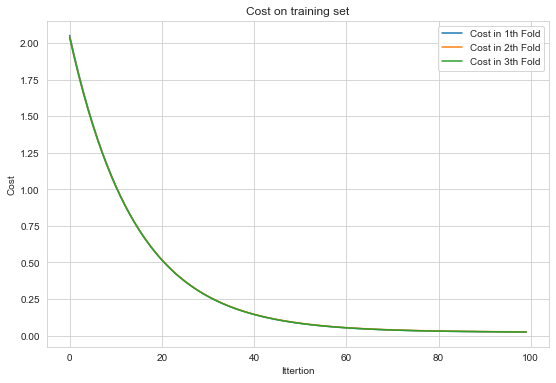

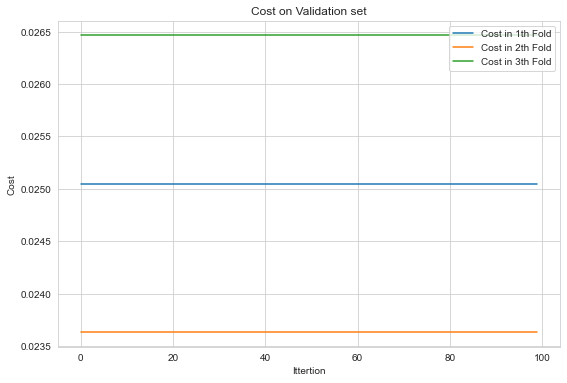

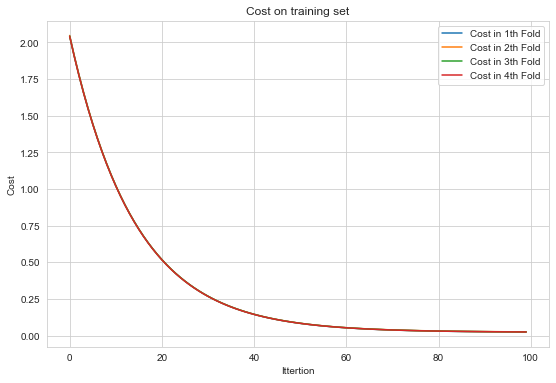

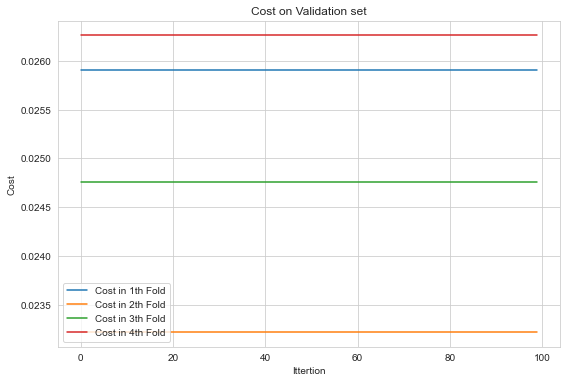

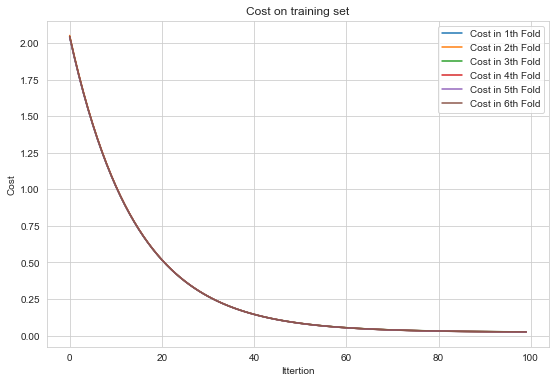

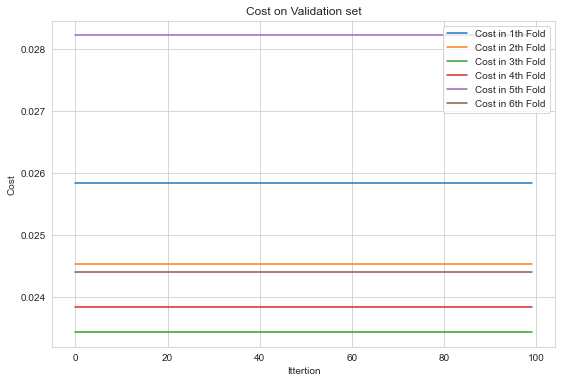

In [33]:
number_kfold = [3,4,6]
x_train,y_train,x_test,y_test = train_test_split(data_train,0.8)
Regression = linear_regresion(x_train)
for i in number_kfold:
  train_cost, dev_cost ,x_lables = Kfold(Regression, i, x_train,y_train, BGD_Lasso)
  plot(Regression.iteration, train_cost, x_lables,title = "Cost on training set")
  plot(Regression.iteration, dev_cost, x_lables,title = "Cost on Validation set")

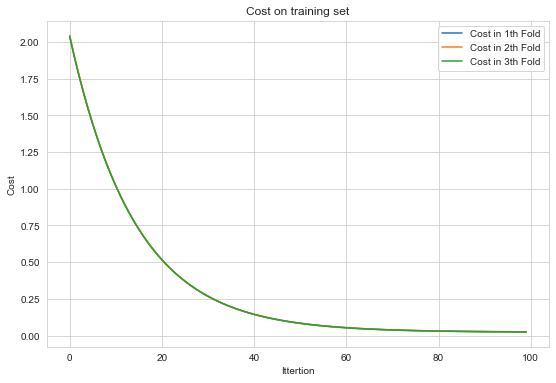

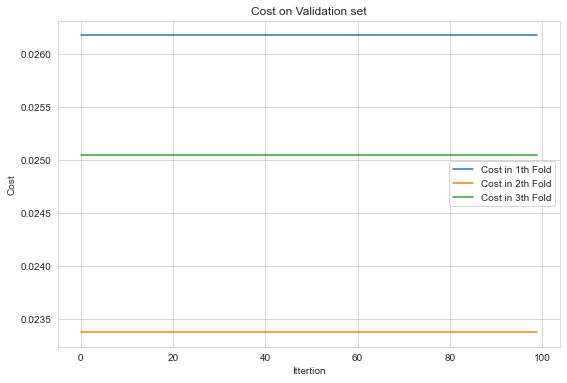

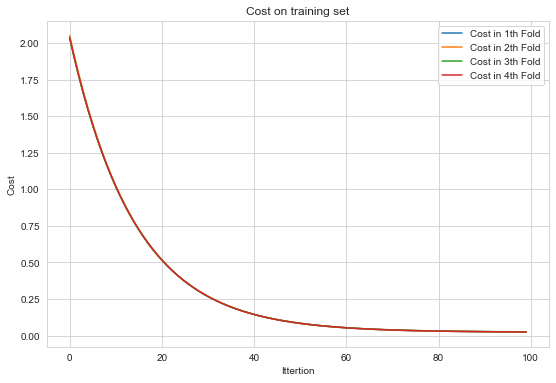

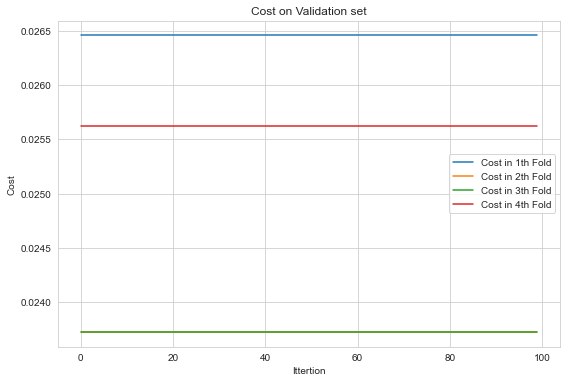

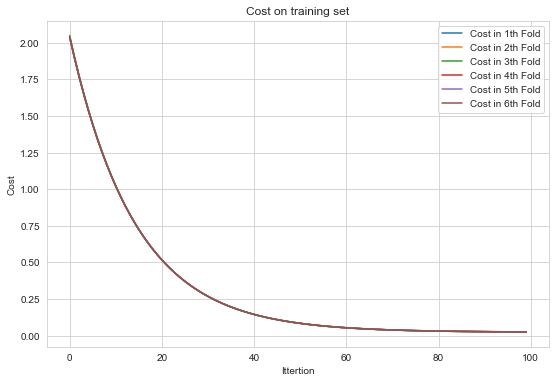

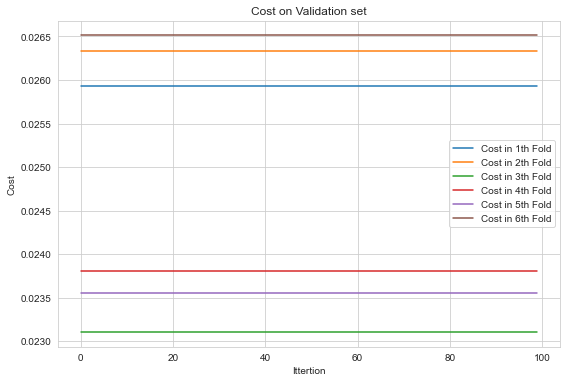

In [34]:
number_kfold = [3,4,6]
x_train,y_train,x_test,y_test = train_test_split(data_train,0.6)
Regression = linear_regresion(x_train)
for i in number_kfold:
  train_cost, dev_cost ,x_lables = Kfold(Regression, i, x_train,y_train, BGD_Lasso)
  plot(Regression.iteration, train_cost, x_lables,title = "Cost on training set")
  plot(Regression.iteration, dev_cost, x_lables,title = "Cost on Validation set")

قسمت گ

In [35]:
x_train,y_train,x_test,y_test = train_test_split(data_train,0.8)
Regression = linear_regresion(x_train)
x_lable = ['BGD_Mse', 'BGD_Mae', 'Ridge_Mse', 'Ridge_Mae','Lasso_Mse', 'Lasso_Mae']

BGD_cost, BGD_theta = BGD_Mse(Regression,x_train,y_train)
BGD_test_Mse = evaluate(BGD_theta, x_test,y_test,MSE_function)
BGD_test_Mae = evaluate(BGD_theta, x_test,y_test,MAE_function)

Ridge_cost, Ridge_theta = BGD_Ridge(Regression,x_train,y_train)
Ridge_test_Mse = evaluate(Ridge_theta, x_test,y_test,MSE_function)
Ridge_test_Mae = evaluate(Ridge_theta, x_test,y_test,MAE_function)

Lasso_cost, Lasso_theta = BGD_Lasso(Regression,x_train,y_train)
Lasso_test_Mse = evaluate(Lasso_theta, x_test,y_test,MSE_function)
Lasso_test_Mae = evaluate(Lasso_theta, x_test,y_test,MAE_function)

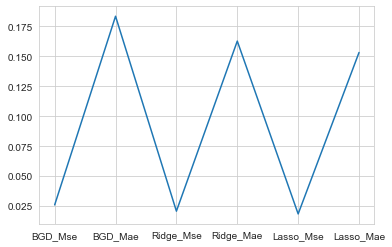

In [36]:
plt.plot(x_lable,[BGD_test_Mse,BGD_test_Mae,Ridge_test_Mse,Ridge_test_Mae,Lasso_test_Mse,Lasso_test_Mae])
plt.show()

قسمت ل

In [37]:
x_train,y_train,x_test,y_test = train_test_split(data_train,0.8)
Regression = linear_regresion(x_train,learning_rate=0.0001)
Ridge_cost_1, _ = BGD_Ridge(Regression,x_train,y_train)
Lasso_cost_1, _ = BGD_Lasso(Regression,x_train,y_train)
x_lablel = ['BGD_Ridge_0.0001', 'BGD_Lasso_0.0001','BGD_Ridge_0.01','BGD_Lasso_0.01']

Regression = linear_regresion(x_train,learning_rate=0.01)
Ridge_cost_001, _ = BGD_Ridge(Regression,x_train,y_train)
Lasso_cost_001, _ = BGD_Lasso(Regression,x_train,y_train)


با توجه به نمودار پایین میزان خطا با نرخ یادگیری یک صدم کمتر میباشد

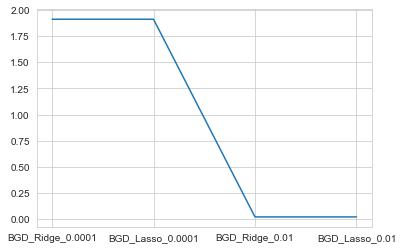

In [38]:
plt.plot(x_lablel, [Ridge_cost_1[-1],Lasso_cost_1[-1],Ridge_cost_001[-1],Lasso_cost_001[-1]])

با توجه به نمودار پایین ضریب پنالتی یک صدم خطای بیشتری را دارد

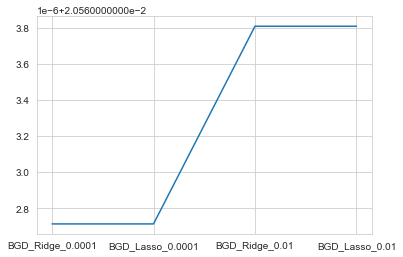

In [39]:
x_train,y_train,x_test,y_test = train_test_split(data_train,0.8)
Regression = linear_regresion(x_train,landa=0.0001)
Ridge_cost_1, _ = BGD_Ridge(Regression,x_train,y_train)
Lasso_cost_1, _ = BGD_Lasso(Regression,x_train,y_train)
x_lablel = ['BGD_Ridge_0.0001', 'BGD_Lasso_0.0001','BGD_Ridge_0.01','BGD_Lasso_0.01']

Regression = linear_regresion(x_train,landa=0.01)
Ridge_cost_001, _ = BGD_Ridge(Regression,x_train,y_train)
Lasso_cost_001, _ = BGD_Lasso(Regression,x_train,y_train)
plt.plot(x_lablel, [Ridge_cost_1[-1],Lasso_cost_1[-1],Ridge_cost_001[-1],Lasso_cost_001[-1]])

قسمت م

In [40]:
def BGD_Mse_2(Regression,x_train,y_train,cost_function):
  for iter in range(Regression.iteration):
    h = hypothesis(Regression.theta,x_train)
    Regression.theta[0] = Regression.theta[0] - (Regression.learning_rate/x_train.shape[0]) * sum(h - y_train)
    for j in range(1,Regression.number_of_features + 1):
      if j == 6 or j == 8:
        Regression.theta[j] = Regression.theta[j] - (Regression.learning_rate/x_train.shape[0]) * np.sum((h-y_train) * Regression.theta[j] * x_train.transpose()[j-1])
      else:
        Regression.theta[j] = Regression.theta[j] - (Regression.learning_rate/x_train.shape[0]) * np.sum((h-y_train) * x_train.transpose()[j-1])
    h = hypothesis(Regression.theta, x_train)
    Regression.cost[iter] = cost_function(h,y_train,x_train.shape[0])
  return Regression.cost, Regression.theta

In [41]:
x_train,y_train,x_test,y_test = train_test_split(data_train,0.8)
Regression = linear_regresion(x_train)
cost_mse , _ = BGD_Mse_2(Regression,x_train,y_train,MSE_function)
cost_mae , _ = BGD_Mse_2(Regression,x_train,y_train,MAE_function)

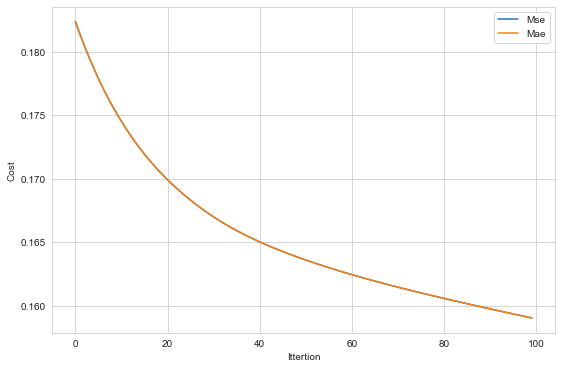

In [42]:
tmp = np.zeros((Regression.iteration,2))
tmp[:,0] = cost_mse[:,0]
tmp[:,1] = cost_mae[:,0]
plot(Regression.iteration,tmp,['Mse','Mae'])

In [52]:
x_train, y_train, _, _ = train_test_split(data_train,1.0)
Regression = linear_regresion(x_train)
Ridge_cost, Ridge_theta = BGD_Ridge(Regression,x_train,y_train)
Lasso_cost, Lasso_theta = BGD_Lasso(Regression,x_train,y_train)


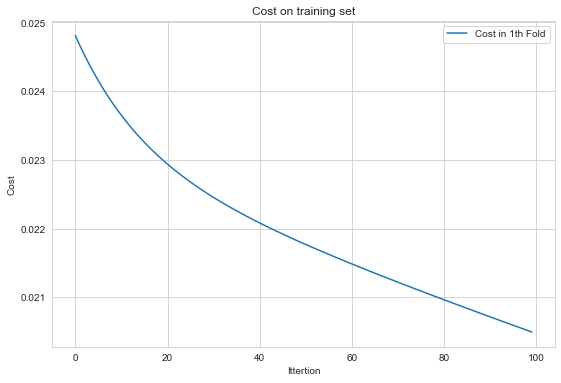

In [53]:
plot(Regression.iteration, Ridge_cost, x_lables,title = "Cost on training set")

In [94]:
data_test = remove_missing_values(data_test)

In [103]:
result_test = hypothesis(Ridge_theta,data_test)

In [107]:
df_sample_submission

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,503.315029
1,FDW14,OUT017,496.689071
2,NCN55,OUT010,607.085638
3,FDQ58,OUT017,399.954832
4,FDY38,OUT027,530.415341
...,...,...,...
5676,FDB58,OUT046,192.898290
5677,FDD47,OUT018,219.887593
5678,NCO17,OUT045,617.075986
5679,FDJ26,OUT017,292.586989


In [105]:
df_sample_submission = df_sample_submission.astype({'Item_Outlet_Sales': float})

In [106]:
df_sample_submission['Item_Outlet_Sales'] = result_test

In [109]:
df_sample_submission.to_csv('test_result.csv',index=False)